# Adult Census Income Classification using Meta Learning

In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from numpy import mean, std

In [2]:
#reading the dataset and converting it to dataframe
df = pd.read_csv("../input/adult-census-income/adult.csv")

In [3]:
#Viewing the top 5 rows of our dataset
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Exploratory Data Analysis

**Income - Target column**

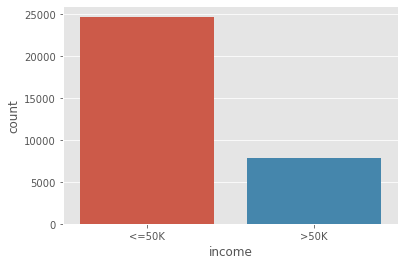

In [4]:
sns.countplot(df.income)

*As we can see, there is a **class imbalance**. The ">50K" class is comparatively very less. So, we will do **Random Over-Sampling** during preprocessing.*


**Age**

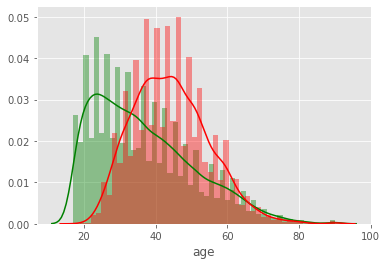

In [5]:
sns.distplot(df[df.income=='<=50K'].age, color='g')
sns.distplot(df[df.income=='>50K'].age, color='r')

*We can observe a rough margin **around 30**. We will divide age into 2 parts ie. under 30 and over 30. We need to check if its useful for our model during testing.*

**Workclass**

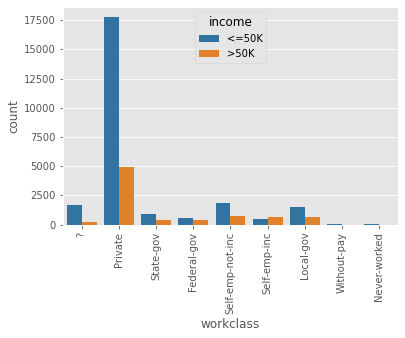

In [6]:
plt.xticks(rotation=90)
sns.countplot(df.workclass, hue=df.income, palette='tab10')

*Majority of the data falls under **Private**. So, we will convert this into Private and not-Private.*

**fnlwgt**

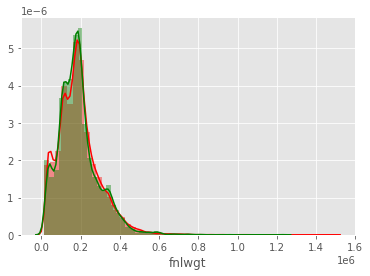

In [7]:
sns.distplot(df[df.income=='<=50K'].fnlwgt, color='r')
sns.distplot(df[df.income=='>50K'].fnlwgt, color='g')

*This is a very **ambiguous** attribute. Will check during testing.*

**Education**

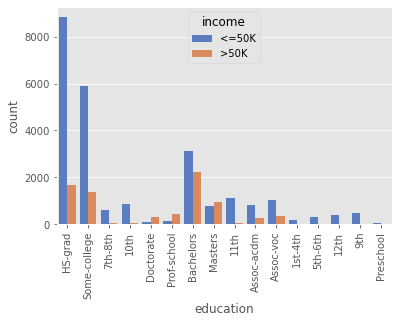

In [8]:
plt.xticks(rotation=90)
sns.countplot(df.education, hue=df.income, palette='muted')

**education.num**

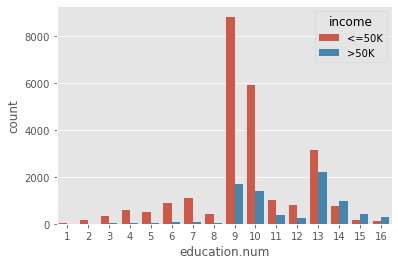

In [9]:
sns.countplot(df["education.num"], hue=df.income)

**marital.status**

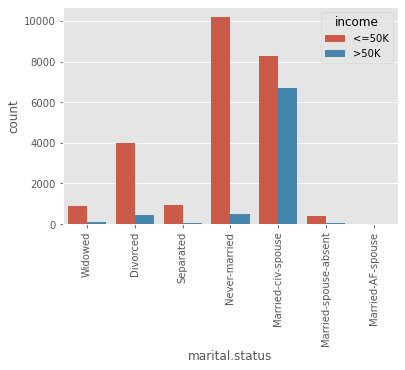

In [10]:
plt.xticks(rotation=90)
sns.countplot(df['marital.status'], hue=df.income)

*We observe that the majority of ">50K" class is **Married-civ-spouse**. So we ll make it 1 and others 0*

**occupation**

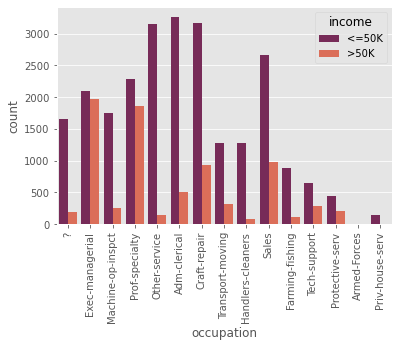

In [11]:
plt.xticks(rotation=90)
sns.countplot(df.occupation, hue=df.income, palette='rocket')

**relationship**

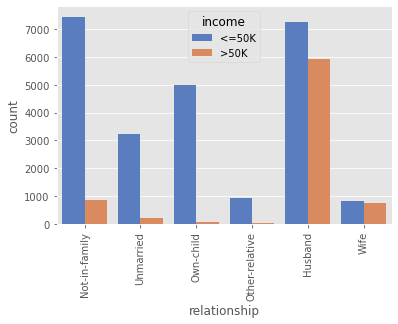

In [12]:
plt.xticks(rotation=90)
sns.countplot(df.relationship, hue=df.income, palette='muted')

**race**

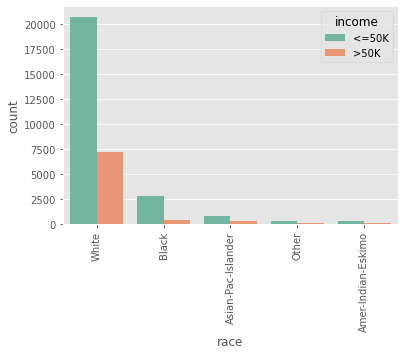

In [13]:
plt.xticks(rotation=90)
sns.countplot(df.race, hue=df.income, palette='Set2')

**sex**

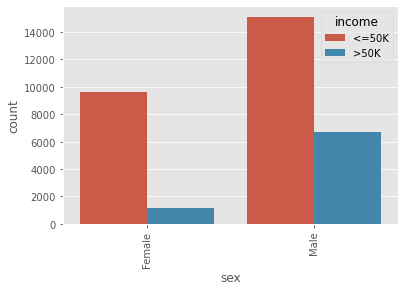

In [14]:
plt.xticks(rotation=90)
sns.countplot(df.sex, hue=df.income)

**capital.gain**

In [15]:
df['capital.gain'].value_counts()

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital.gain, Length: 119, dtype: int64

**capital.loss**

In [16]:
df['capital.loss'].value_counts()

0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital.loss, Length: 92, dtype: int64

**hours.per.week**

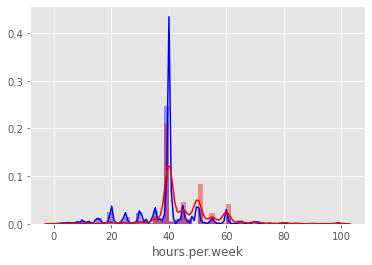

In [17]:
sns.distplot(df[df.income=='<=50K']['hours.per.week'], color='b')
sns.distplot(df[df.income=='>50K']['hours.per.week'], color='r')

**native.country**

In [18]:
df['native.country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

## Preprocessing

### Finding and Handling Missing Data

*Observing the dataset, I found that the null values are marked as "?", So, we will now convert them to numpy.nan(null values).*

In [19]:
df[df.select_dtypes("object") =="?"] = np.nan
nans = df.isnull().sum()
if len(nans[nans>0]):
    print("Missing values detected.\n")
    print(nans[nans>0])
else:
    print("No missing values. You are good to go.")

Missing values detected.

workclass         1836
occupation        1843
native.country     583
dtype: int64


In [20]:
#majority of the values are "Private". Lets fill the missing values as "Private".
df.workclass.fillna("Private", inplace=True)

df.occupation.fillna(method='bfill', inplace=True)

#majority of the values are "United-States". Lets fill the missing values as "United-States".
df['native.country'].fillna("United-States", inplace=True)

print("Handled missing values successfully.")

Handled missing values successfully.


In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y, arr=[]):
        y = column_or_1d(y, warn=True)
        if arr == []:
            arr=y
        self.classes_ = pd.Series(arr).unique()
        return self

le = MyLabelEncoder()

### Feature Engineering and Encoding the columns

In [22]:
# age_enc = pd.cut(df.age, bins=(0,25,45,65,100), labels=(0,1,2,3))
df['age_enc'] = df.age.apply(lambda x: 1 if x > 30 else 0)

def prep_workclass(x):
    if x == 'Never-worked' or x == 'Without-pay':
        return 0
    elif x == 'Private':
        return 1
    elif x == 'State-gov' or x == 'Local-gov' or x == 'Federal-gov':
        return 2
    elif x == 'Self-emp-not-inc':
        return 3
    else:
        return 4

df['workclass_enc'] = df.workclass.apply(prep_workclass)

df['fnlwgt_enc'] = df.fnlwgt.apply(lambda x: 0 if x>200000 else 1)

le.fit(df.education, arr=['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th','10th', '11th', '12th', 
                                             'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', 'Some-college', 'Bachelors', 'Masters', 'Doctorate'])
df['education_enc'] = le.transform(df.education)


df['education.num_enc'] = df['education.num'].apply(lambda x: 1 if x>=9 else 0)

df['marital.status_enc'] = df['marital.status'].apply(lambda x: 1 if x=='Married-civ-spouse' or x == 'Married-AF-spouse' else 0)

def prep_occupation(x):
    if x in ['Prof-specialty', 'Exec-managerial', 'Tech-support', 'Protective-serv']:
        return 2
    elif x in ['Sales', 'Craft-repair']:
        return 1
    else:
        return 0

df['occupation_enc'] = df.occupation.apply(prep_occupation)

df['relationship_enc'] = df.relationship.apply(lambda x: 1 if x in ['Husband', 'Wife'] else 0)

df['race_enc'] = df.race.apply(lambda x: 1 if x=='White' else 0)

df['sex_enc'] = df.sex.apply(lambda x: 1 if x=='Male' else 0)

df['capital.gain_enc'] = pd.cut(df["capital.gain"], 
                                bins=[-1,0,df[df["capital.gain"]>0]["capital.gain"].median(), df["capital.gain"].max()], labels=(0,1,2)).astype('int64')

df['capital.loss_enc'] = pd.cut(df["capital.loss"], 
                                bins=[-1,0,df[df["capital.loss"]>0]["capital.loss"].median(), df["capital.loss"].max()], labels=(0,1,2)).astype('int64')

# hpw_enc = pd.cut(df['hours.per.week'], bins= (0,30,40,53,168), labels=(0,1,2,3))
df['hours.per.week_enc'] = pd.qcut(df['hours.per.week'], q=5, labels=(0,1,2,3), duplicates='drop').astype('int64')

df['native.country_enc'] = df['native.country'].apply(lambda x: 1 if x=='United-States' else 0)

df['income_enc'] = df.income.apply(lambda x: 1 if x==">50K" else 0)

print("Encoding complete.")

Encoding complete.


In [23]:
df.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       32561 non-null  object
 1   education       32561 non-null  object
 2   marital.status  32561 non-null  object
 3   occupation      32561 non-null  object
 4   relationship    32561 non-null  object
 5   race            32561 non-null  object
 6   sex             32561 non-null  object
 7   native.country  32561 non-null  object
 8   income          32561 non-null  object
dtypes: object(9)
memory usage: 2.2+ MB


In [24]:
#dropping encoded columns - education, sex, income
df.drop(['education', 'sex', 'income'], 1, inplace=True)

### Label Encoding without Feature Engineering

In [25]:
for feature in df.select_dtypes("object").columns:
    df[feature]=le.fit_transform(df[feature])

### Feature Selection

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 32561 non-null  int64
 1   workclass           32561 non-null  int64
 2   fnlwgt              32561 non-null  int64
 3   education.num       32561 non-null  int64
 4   marital.status      32561 non-null  int64
 5   occupation          32561 non-null  int64
 6   relationship        32561 non-null  int64
 7   race                32561 non-null  int64
 8   capital.gain        32561 non-null  int64
 9   capital.loss        32561 non-null  int64
 10  hours.per.week      32561 non-null  int64
 11  native.country      32561 non-null  int64
 12  age_enc             32561 non-null  int64
 13  workclass_enc       32561 non-null  int64
 14  fnlwgt_enc          32561 non-null  int64
 15  education_enc       32561 non-null  int64
 16  education.num_enc   32561 non-null  int6

<BarContainer object of 26 artists>

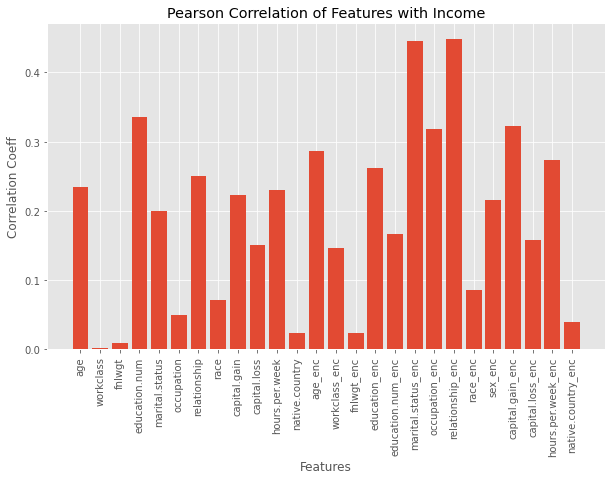

In [27]:
#Visualizing the pearson correlation with the target class
pcorr = df.drop('income_enc',1).corrwith(df.income_enc)
plt.figure(figsize=(10,6))
plt.title("Pearson Correlation of Features with Income")
plt.xlabel("Features")
plt.ylabel("Correlation Coeff")
plt.xticks(rotation=90)
plt.bar(pcorr.index, list(map(abs,pcorr.values)))

From the pearson correlation plot, we can see that correlation of few columns are very **low** with the target column, so, we ll drop them.

In [28]:
df.drop(['workclass', 'fnlwgt','occupation', 'race', 'native.country', 'fnlwgt_enc', 'race_enc', 'native.country_enc'], 1, inplace=True)

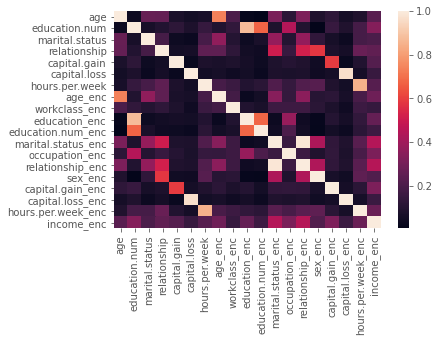

In [29]:
sns.heatmap(df.corr().apply(abs))

**Dropping redundant features**

We can see that **education_enc, education.num_enc and education.num** as well as **relationship_enc and marital.status_enc** have **high correlation**. So, we will only keep one of them based on their correlation with income_enc.

We also have some redundant feautres as we have engineered features from them(age, capital.gain, etc.).

In [30]:
df.drop(['age', 'education.num_enc', 'education_enc', 'marital.status_enc', 'capital.gain', 'capital.loss', 'hours.per.week'], 1, inplace = True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   education.num       32561 non-null  int64
 1   marital.status      32561 non-null  int64
 2   relationship        32561 non-null  int64
 3   age_enc             32561 non-null  int64
 4   workclass_enc       32561 non-null  int64
 5   occupation_enc      32561 non-null  int64
 6   relationship_enc    32561 non-null  int64
 7   sex_enc             32561 non-null  int64
 8   capital.gain_enc    32561 non-null  int64
 9   capital.loss_enc    32561 non-null  int64
 10  hours.per.week_enc  32561 non-null  int64
 11  income_enc          32561 non-null  int64
dtypes: int64(12)
memory usage: 3.0 MB


In [32]:
X = df.drop('income_enc', 1)
y = df.income_enc

### Train Test Split (3:1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [34]:
print("No. of rows in training data:",X_train.shape[0])
print("No. of rows in testing data:",X_test.shape[0])

No. of rows in training data: 24420
No. of rows in testing data: 8141


### Random Over Sampling

*We can see the class imbalance in our target. This results in models that have poor predictive performance, specifically for the minority class. So, we need to random over sampling*

In [35]:
oversample = RandomOverSampler(sampling_strategy='minority') #100% oversampling
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [36]:
y_over.value_counts()

1    18539
0    18539
Name: income_enc, dtype: int64

In [37]:
oversample = RandomOverSampler(sampling_strategy=0.75) #75% oversampling
X_75_over, y_75_over = oversample.fit_resample(X_train, y_train)

In [38]:
y_75_over.value_counts()

0    18539
1    13904
Name: income_enc, dtype: int64

## Model Preparation

In [39]:
#Model Imports
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [40]:
seed= 42

In [41]:
models = {
    'LR':LogisticRegression(random_state=seed),
    'SVC':SVC(random_state=seed),
    'KNN':KNeighborsClassifier(),
    'AB':AdaBoostClassifier(random_state=seed),
    'ET':ExtraTreesClassifier(random_state=seed),
    'GB':GradientBoostingClassifier(random_state=seed),
    'RF':RandomForestClassifier(random_state=seed),
    'XGB':XGBClassifier(random_state=seed),
    'LGBM':LGBMClassifier(random_state=seed)
    }

In [42]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = StratifiedKFold(shuffle=True, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [43]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('*%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

*LR 0.846 (0.003)
*SVC 0.846 (0.002)
*KNN 0.833 (0.005)
*AB 0.852 (0.003)
*ET 0.842 (0.003)
*GB 0.854 (0.002)
*RF 0.842 (0.002)
*XGB 0.849 (0.002)
*LGBM 0.852 (0.002)


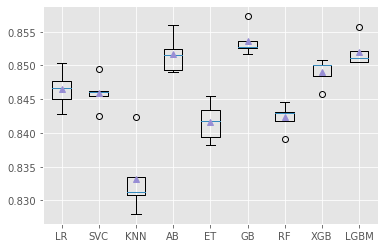

In [44]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()